🚀 Kubernetes Predictive Auto-Scaler with ML

📈 Step 1: Generating Kubernetes cluster metrics (30 days, 5-min intervals)...
✓ Generated 8640 metric data points

🤖 Step 2: Training predictive ML models...
✓ Traffic Prediction Model Trained
  MAE: 18.11 RPS | RMSE: 36.74 RPS

✓ Resource Prediction Model Trained
  MAE: 0.35% CPU | RMSE: 0.50% CPU

📊 Top 5 Traffic Prediction Features:
  is_business_hours: 0.5435
  rps_rate_of_change: 0.1656
  rps_lag_1: 0.1313
  rps_rolling_mean: 0.0712
  day_sin: 0.0310

🔮 Step 3: Predicting load for next 24 hours...
✓ Generated 24 hourly predictions

⚡ Step 4: Generating auto-scaling recommendations...
✓ Generated 24 scaling decisions

🚀 KUBERNETES PREDICTIVE AUTO-SCALER REPORT

📊 CURRENT CLUSTER STATUS
--------------------------------------------------------------------------------
Average RPS (Last Hour):        746.60
Peak RPS (Last Hour):           794.39
Average CPU Utilization:        11.77%
Average Memory Utilization:     4.60%
Average Response Tim

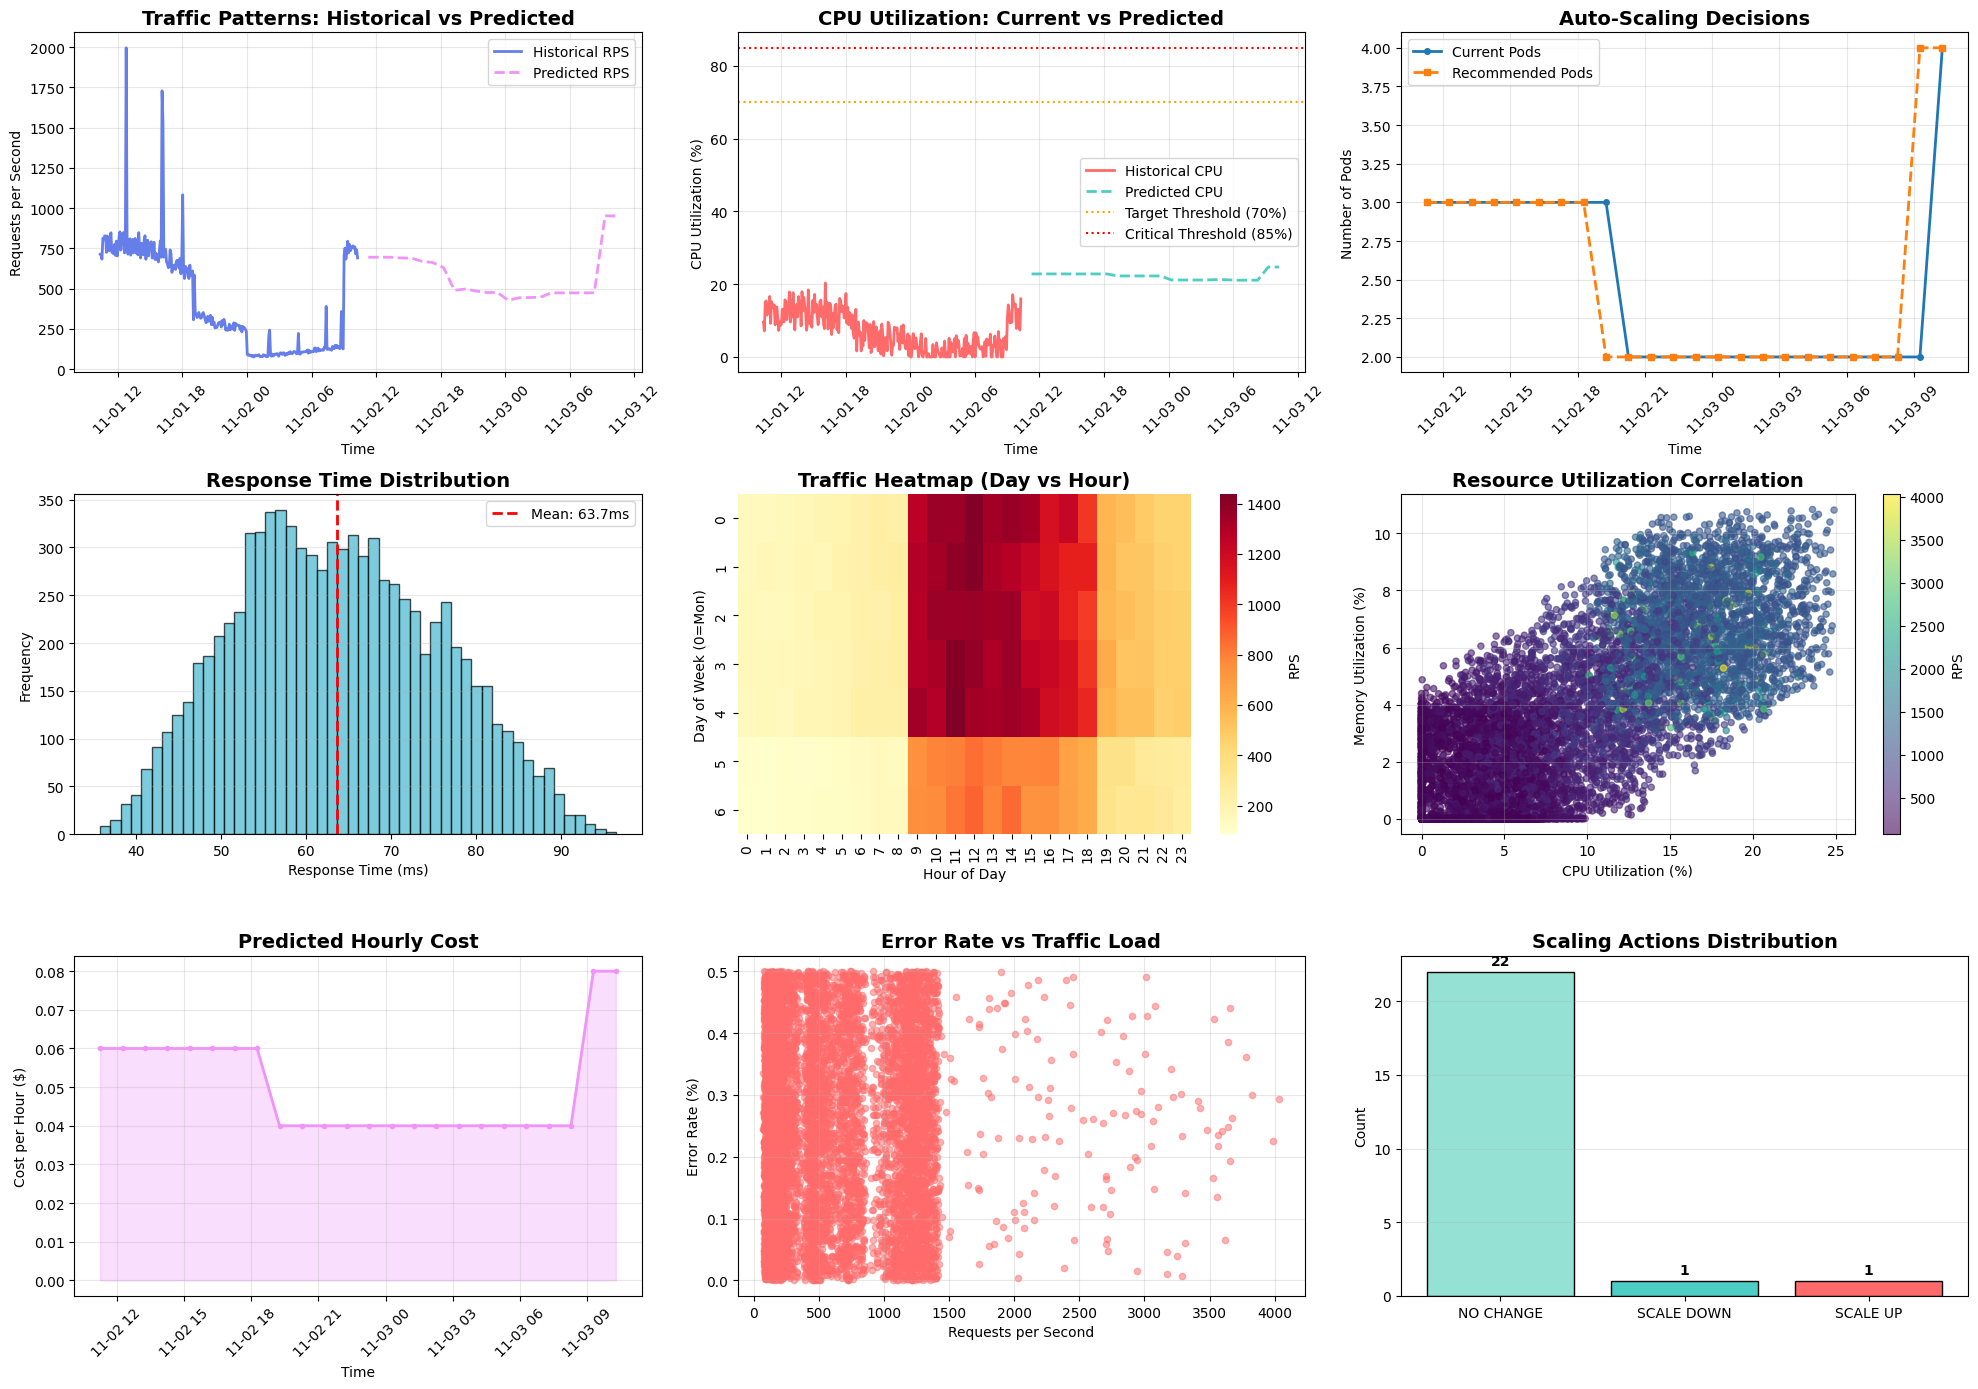


✅ Predictive auto-scaling analysis complete!


In [5]:
"""
DevOps Project 2: Kubernetes Auto-Scaler with Predictive Analytics
An intelligent system that predicts pod resource requirements and automatically scales
Kubernetes clusters based on ML-forecasted traffic patterns and resource utilization.
"""

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class K8sPredictiveAutoScaler:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.traffic_model = GradientBoostingRegressor(n_estimators=150, random_state=42)
        self.resource_model = GradientBoostingRegressor(n_estimators=150, random_state=42)
        self.metrics_data = None
        self.predictions = None
        self.scaling_decisions = []
        self.current_pods = 3  # Initial pod count

    def generate_cluster_metrics(self, days=30, interval_minutes=5):
        """Generate realistic Kubernetes cluster metrics"""
        # Calculate number of data points
        points_per_day = (24 * 60) // interval_minutes
        total_points = days * points_per_day

        timestamps = pd.date_range(
            end=datetime.now(),
            periods=total_points,
            freq=f'{interval_minutes}min'
        )

        data = []
        for i, ts in enumerate(timestamps):
            hour = ts.hour
            day_of_week = ts.weekday()

            # Simulate realistic traffic patterns
            # Base traffic with time-of-day variation
            if 9 <= hour <= 18:  # Business hours
                base_traffic = 1000
            elif 18 <= hour <= 23:  # Evening
                base_traffic = 600
            else:  # Night
                base_traffic = 200

            # Weekly pattern (lower on weekends)
            if day_of_week >= 5:  # Weekend
                base_traffic *= 0.6

            # Add hourly variation
            hourly_factor = 1 + 0.3 * np.sin((hour - 6) * np.pi / 12)

            # Random spikes (traffic surges)
            if np.random.random() < 0.05:  # 5% chance of spike
                spike_factor = np.random.uniform(1.5, 3.0)
            else:
                spike_factor = 1.0

            # Calculate requests per second
            rps = base_traffic * hourly_factor * spike_factor * np.random.uniform(0.9, 1.1)

            # Calculate resource utilization based on traffic
            cpu_per_request = 0.05  # 5% CPU per 100 RPS
            memory_per_request = 0.02  # 2% memory per 100 RPS

            current_pods_sim = max(3, int(rps / 300))  # 1 pod per 300 RPS

            cpu_util = min(95, (rps * cpu_per_request) / current_pods_sim + np.random.uniform(-5, 5))
            memory_util = min(90, (rps * memory_per_request) / current_pods_sim + np.random.uniform(-3, 3))

            # Response time increases with high utilization
            if cpu_util > 80:
                response_time = 200 + (cpu_util - 80) * 10
            else:
                response_time = 50 + cpu_util * 1.5

            response_time += np.random.uniform(-10, 10)

            # Network throughput
            network_mbps = (rps * 0.5) + np.random.uniform(-50, 50)

            # Error rate increases with high load
            if cpu_util > 85:
                error_rate = (cpu_util - 85) * 0.5
            else:
                error_rate = np.random.uniform(0, 0.5)

            data.append({
                'timestamp': ts,
                'requests_per_second': round(rps, 2),
                'cpu_utilization': round(max(0, cpu_util), 2),
                'memory_utilization': round(max(0, memory_util), 2),
                'response_time_ms': round(max(10, response_time), 2),
                'network_throughput_mbps': round(max(0, network_mbps), 2),
                'error_rate_percent': round(max(0, error_rate), 3),
                'active_pods': current_pods_sim,
                'hour': hour,
                'day_of_week': day_of_week,
                'is_business_hours': 1 if 9 <= hour <= 18 else 0,
                'is_weekend': 1 if day_of_week >= 5 else 0
            })

        self.metrics_data = pd.DataFrame(data)
        return self.metrics_data

    def engineer_features(self, df):
        """Create time-series features for prediction"""
        df = df.copy()

        # Time-based features
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

        # Lag features (previous values)
        df['rps_lag_1'] = df['requests_per_second'].shift(1).fillna(df['requests_per_second'].mean())
        df['rps_lag_2'] = df['requests_per_second'].shift(2).fillna(df['requests_per_second'].mean())
        df['rps_lag_12'] = df['requests_per_second'].shift(12).fillna(df['requests_per_second'].mean())  # 1 hour ago

        df['cpu_lag_1'] = df['cpu_utilization'].shift(1).fillna(df['cpu_utilization'].mean())
        df['memory_lag_1'] = df['memory_utilization'].shift(1).fillna(df['memory_utilization'].mean())

        # Rolling statistics
        df['rps_rolling_mean'] = df['requests_per_second'].rolling(12, min_periods=1).mean()
        df['rps_rolling_std'] = df['requests_per_second'].rolling(12, min_periods=1).std().fillna(0)
        df['cpu_rolling_mean'] = df['cpu_utilization'].rolling(12, min_periods=1).mean()

        # Rate of change
        df['rps_rate_of_change'] = df['requests_per_second'].diff().fillna(0)
        df['cpu_rate_of_change'] = df['cpu_utilization'].diff().fillna(0)

        return df

    def train_prediction_models(self):
        """Train ML models for traffic and resource prediction"""
        df = self.engineer_features(self.metrics_data)

        # Features for prediction
        feature_cols = [
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'is_business_hours', 'is_weekend',
            'rps_lag_1', 'rps_lag_2', 'rps_lag_12',
            'cpu_lag_1', 'memory_lag_1',
            'rps_rolling_mean', 'rps_rolling_std', 'cpu_rolling_mean',
            'rps_rate_of_change', 'cpu_rate_of_change'
        ]

        # Prepare data
        df_clean = df[feature_cols + ['requests_per_second', 'cpu_utilization']].dropna()

        X = df_clean[feature_cols]
        y_traffic = df_clean['requests_per_second']
        y_cpu = df_clean['cpu_utilization']

        # Split data (80% train, 20% test)
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_traffic_train, y_traffic_test = y_traffic[:split_idx], y_traffic[split_idx:]
        y_cpu_train, y_cpu_test = y_cpu[:split_idx], y_cpu[split_idx:]

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train traffic prediction model
        self.traffic_model.fit(X_train_scaled, y_traffic_train)
        traffic_pred = self.traffic_model.predict(X_test_scaled)
        traffic_mae = mean_absolute_error(y_traffic_test, traffic_pred)
        traffic_rmse = np.sqrt(mean_squared_error(y_traffic_test, traffic_pred))

        # Train resource prediction model
        self.resource_model.fit(X_train_scaled, y_cpu_train)
        cpu_pred = self.resource_model.predict(X_test_scaled)
        cpu_mae = mean_absolute_error(y_cpu_test, cpu_pred)
        cpu_rmse = np.sqrt(mean_squared_error(y_cpu_test, cpu_pred))

        print(f"✓ Traffic Prediction Model Trained")
        print(f"  MAE: {traffic_mae:.2f} RPS | RMSE: {traffic_rmse:.2f} RPS")
        print(f"\n✓ Resource Prediction Model Trained")
        print(f"  MAE: {cpu_mae:.2f}% CPU | RMSE: {cpu_rmse:.2f}% CPU")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'traffic_importance': self.traffic_model.feature_importances_,
            'resource_importance': self.resource_model.feature_importances_
        }).sort_values('traffic_importance', ascending=False)

        print("\n📊 Top 5 Traffic Prediction Features:")
        for idx, row in feature_importance.head().iterrows():
            print(f"  {row['feature']}: {row['traffic_importance']:.4f}")

        return traffic_mae, cpu_mae

    def predict_future_load(self, hours_ahead=24):
        """Predict traffic and resource utilization for next N hours"""
        last_row = self.engineer_features(self.metrics_data).iloc[-1]
        last_timestamp = self.metrics_data['timestamp'].iloc[-1]

        predictions = []

        for h in range(1, hours_ahead + 1):
            future_timestamp = last_timestamp + timedelta(hours=h)
            hour = future_timestamp.hour
            day_of_week = future_timestamp.weekday()

            # Create feature vector
            features = {
                'hour_sin': np.sin(2 * np.pi * hour / 24),
                'hour_cos': np.cos(2 * np.pi * hour / 24),
                'day_sin': np.sin(2 * np.pi * day_of_week / 7),
                'day_cos': np.cos(2 * np.pi * day_of_week / 7),
                'is_business_hours': 1 if 9 <= hour <= 18 else 0,
                'is_weekend': 1 if day_of_week >= 5 else 0,
                'rps_lag_1': last_row['requests_per_second'],
                'rps_lag_2': last_row['rps_lag_1'],
                'rps_lag_12': last_row['rps_lag_12'],
                'cpu_lag_1': last_row['cpu_utilization'],
                'memory_lag_1': last_row['memory_utilization'],
                'rps_rolling_mean': last_row['rps_rolling_mean'],
                'rps_rolling_std': last_row['rps_rolling_std'],
                'cpu_rolling_mean': last_row['cpu_rolling_mean'],
                'rps_rate_of_change': last_row['rps_rate_of_change'],
                'cpu_rate_of_change': last_row['cpu_rate_of_change']
            }

            X_pred = pd.DataFrame([features])
            X_pred_scaled = self.scaler.transform(X_pred)

            # Predict
            predicted_rps = self.traffic_model.predict(X_pred_scaled)[0]
            predicted_cpu = self.resource_model.predict(X_pred_scaled)[0]

            # Calculate recommended pods
            recommended_pods = self.calculate_required_pods(predicted_rps, predicted_cpu)

            predictions.append({
                'timestamp': future_timestamp,
                'predicted_rps': round(predicted_rps, 2),
                'predicted_cpu': round(predicted_cpu, 2),
                'recommended_pods': recommended_pods,
                'hour': hour,
                'is_business_hours': 1 if 9 <= hour <= 18 else 0
            })

        self.predictions = pd.DataFrame(predictions)
        return self.predictions

    def calculate_required_pods(self, rps, cpu_util):
        """Calculate optimal number of pods based on predicted load"""
        # Target: Keep CPU below 70% for headroom
        target_cpu = 70

        # Calculate pods based on RPS (1 pod per 300 RPS)
        pods_by_rps = max(2, int(np.ceil(rps / 300)))

        # Calculate pods based on CPU
        if cpu_util > target_cpu:
            scale_factor = cpu_util / target_cpu
            pods_by_cpu = max(2, int(np.ceil(self.current_pods * scale_factor)))
        else:
            pods_by_cpu = max(2, int(np.ceil(self.current_pods * (cpu_util / target_cpu))))

        # Take the maximum of both calculations
        required_pods = max(pods_by_rps, pods_by_cpu)

        # Apply limits (min 2, max 50)
        required_pods = max(2, min(50, required_pods))

        return required_pods

    def generate_scaling_decisions(self):
        """Generate scaling recommendations with decision logic"""
        if self.predictions is None:
            print("❌ No predictions available. Run predict_future_load() first.")
            return None

        decisions = []
        current_pods = self.current_pods

        for idx, row in self.predictions.iterrows():
            recommended_pods = row['recommended_pods']

            # Scaling decision logic
            if recommended_pods > current_pods:
                action = "SCALE UP"
                reason = f"High load predicted: {row['predicted_rps']:.0f} RPS, {row['predicted_cpu']:.1f}% CPU"
                priority = "HIGH" if row['predicted_cpu'] > 80 else "MEDIUM"
            elif recommended_pods < current_pods:
                action = "SCALE DOWN"
                reason = f"Low load predicted: {row['predicted_rps']:.0f} RPS, {row['predicted_cpu']:.1f}% CPU"
                priority = "LOW"
            else:
                action = "NO CHANGE"
                reason = "Optimal pod count"
                priority = "INFO"

            # Calculate cost impact (assuming $0.02 per pod-hour)
            cost_per_hour = recommended_pods * 0.02
            cost_change = (recommended_pods - current_pods) * 0.02

            decisions.append({
                'timestamp': row['timestamp'],
                'current_pods': current_pods,
                'recommended_pods': recommended_pods,
                'action': action,
                'priority': priority,
                'reason': reason,
                'predicted_rps': row['predicted_rps'],
                'predicted_cpu': row['predicted_cpu'],
                'cost_per_hour': round(cost_per_hour, 3),
                'cost_impact': round(cost_change, 3)
            })

            # Update current pods for next iteration
            current_pods = recommended_pods

        self.scaling_decisions = pd.DataFrame(decisions)
        return self.scaling_decisions

    def visualize_analysis(self):
        """Create comprehensive visualization of autoscaling analysis"""
        fig = plt.figure(figsize=(20, 14))

        # 1. Historical RPS with predictions
        ax1 = plt.subplot(3, 3, 1)
        recent_data = self.metrics_data.tail(288)  # Last day
        ax1.plot(recent_data['timestamp'], recent_data['requests_per_second'],
                label='Historical RPS', linewidth=2, color='#667eea')
        if self.predictions is not None:
            ax1.plot(self.predictions['timestamp'], self.predictions['predicted_rps'],
                    label='Predicted RPS', linestyle='--', linewidth=2, color='#f093fb')
        ax1.set_title('Traffic Patterns: Historical vs Predicted', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Requests per Second')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # 2. CPU utilization trends
        ax2 = plt.subplot(3, 3, 2)
        ax2.plot(recent_data['timestamp'], recent_data['cpu_utilization'],
                label='Historical CPU', linewidth=2, color='#FF6B6B')
        if self.predictions is not None:
            ax2.plot(self.predictions['timestamp'], self.predictions['predicted_cpu'],
                    label='Predicted CPU', linestyle='--', linewidth=2, color='#4ECDC4')
        ax2.axhline(y=70, color='orange', linestyle=':', label='Target Threshold (70%)')
        ax2.axhline(y=85, color='red', linestyle=':', label='Critical Threshold (85%)')
        ax2.set_title('CPU Utilization: Current vs Predicted', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('CPU Utilization (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)

        # 3. Pod scaling decisions
        ax3 = plt.subplot(3, 3, 3)
        if self.scaling_decisions is not None:
            ax3.plot(self.scaling_decisions['timestamp'],
                    self.scaling_decisions['current_pods'],
                    label='Current Pods', linewidth=2, marker='o', markersize=4)
            ax3.plot(self.scaling_decisions['timestamp'],
                    self.scaling_decisions['recommended_pods'],
                    label='Recommended Pods', linestyle='--', linewidth=2, marker='s', markersize=4)
        ax3.set_title('Auto-Scaling Decisions', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Number of Pods')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)

        # 4. Response time distribution
        ax4 = plt.subplot(3, 3, 4)
        ax4.hist(self.metrics_data['response_time_ms'], bins=50, color='#45B7D1', alpha=0.7, edgecolor='black')
        ax4.axvline(self.metrics_data['response_time_ms'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Mean: {self.metrics_data["response_time_ms"].mean():.1f}ms')
        ax4.set_title('Response Time Distribution', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Response Time (ms)')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')

        # 5. Traffic heatmap by hour and day
        ax5 = plt.subplot(3, 3, 5)
        pivot_traffic = self.metrics_data.pivot_table(
            values='requests_per_second',
            index='day_of_week',
            columns='hour',
            aggfunc='mean'
        )
        sns.heatmap(pivot_traffic, cmap='YlOrRd', ax=ax5, cbar_kws={'label': 'RPS'})
        ax5.set_title('Traffic Heatmap (Day vs Hour)', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Day of Week (0=Mon)')
        ax5.set_xlabel('Hour of Day')

        # 6. Resource utilization scatter
        ax6 = plt.subplot(3, 3, 6)
        scatter = ax6.scatter(self.metrics_data['cpu_utilization'],
                             self.metrics_data['memory_utilization'],
                             c=self.metrics_data['requests_per_second'],
                             cmap='viridis', alpha=0.6, s=20)
        plt.colorbar(scatter, ax=ax6, label='RPS')
        ax6.set_title('Resource Utilization Correlation', fontsize=14, fontweight='bold')
        ax6.set_xlabel('CPU Utilization (%)')
        ax6.set_ylabel('Memory Utilization (%)')
        ax6.grid(True, alpha=0.3)

        # 7. Cost analysis
        ax7 = plt.subplot(3, 3, 7)
        if self.scaling_decisions is not None:
            ax7.plot(self.scaling_decisions['timestamp'],
                    self.scaling_decisions['cost_per_hour'],
                    linewidth=2, color='#f093fb', marker='o', markersize=3)
            ax7.fill_between(self.scaling_decisions['timestamp'],
                            self.scaling_decisions['cost_per_hour'],
                            alpha=0.3, color='#f093fb')
        ax7.set_title('Predicted Hourly Cost', fontsize=14, fontweight='bold')
        ax7.set_xlabel('Time')
        ax7.set_ylabel('Cost per Hour ($)')
        ax7.grid(True, alpha=0.3)
        ax7.tick_params(axis='x', rotation=45)

        # 8. Error rate vs load
        ax8 = plt.subplot(3, 3, 8)
        ax8.scatter(self.metrics_data['requests_per_second'],
                   self.metrics_data['error_rate_percent'],
                   alpha=0.5, s=20, color='#FF6B6B')
        ax8.set_title('Error Rate vs Traffic Load', fontsize=14, fontweight='bold')
        ax8.set_xlabel('Requests per Second')
        ax8.set_ylabel('Error Rate (%)')
        ax8.grid(True, alpha=0.3)

        # 9. Scaling actions summary
        ax9 = plt.subplot(3, 3, 9)
        if self.scaling_decisions is not None:
            action_counts = self.scaling_decisions['action'].value_counts()
            colors_map = {'SCALE UP': '#FF6B6B', 'SCALE DOWN': '#4ECDC4', 'NO CHANGE': '#95E1D3'}
            colors = [colors_map.get(action, '#CCCCCC') for action in action_counts.index]
            ax9.bar(action_counts.index, action_counts.values, color=colors, edgecolor='black')
            ax9.set_title('Scaling Actions Distribution', fontsize=14, fontweight='bold')
            ax9.set_ylabel('Count')
            for i, v in enumerate(action_counts.values):
                ax9.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
        ax9.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('k8s_autoscaling_analysis.png', dpi=300, bbox_inches='tight')
        print("\n✓ Visualization saved as 'k8s_autoscaling_analysis.png'")
        plt.show()

    def generate_report(self):
        """Generate comprehensive autoscaling report"""
        print("\n" + "="*80)
        print("🚀 KUBERNETES PREDICTIVE AUTO-SCALER REPORT")
        print("="*80)

        # Current cluster status
        print("\n📊 CURRENT CLUSTER STATUS")
        print("-" * 80)
        recent = self.metrics_data.tail(12)  # Last hour
        print(f"Average RPS (Last Hour):        {recent['requests_per_second'].mean():.2f}")
        print(f"Peak RPS (Last Hour):           {recent['requests_per_second'].max():.2f}")
        print(f"Average CPU Utilization:        {recent['cpu_utilization'].mean():.2f}%")
        print(f"Average Memory Utilization:     {recent['memory_utilization'].mean():.2f}%")
        print(f"Average Response Time:          {recent['response_time_ms'].mean():.2f}ms")
        print(f"Current Active Pods:            {self.current_pods}")
        print(f"Error Rate:                     {recent['error_rate_percent'].mean():.3f}%")

        # Predictions
        if self.predictions is not None:
            print("\n🔮 PREDICTIONS (Next 24 Hours)")
            print("-" * 80)
            print(f"Expected Peak RPS:              {self.predictions['predicted_rps'].max():.2f}")
            print(f"Expected Avg RPS:               {self.predictions['predicted_rps'].mean():.2f}")
            print(f"Expected Peak CPU:              {self.predictions['predicted_cpu'].max():.2f}%")
            print(f"Max Recommended Pods:           {self.predictions['recommended_pods'].max()}")
            print(f"Min Recommended Pods:           {self.predictions['recommended_pods'].min()}")

        # Scaling decisions
        if self.scaling_decisions is not None:
            print("\n⚡ AUTO-SCALING RECOMMENDATIONS")
            print("-" * 80)

            scale_up = self.scaling_decisions[self.scaling_decisions['action'] == 'SCALE UP']
            scale_down = self.scaling_decisions[self.scaling_decisions['action'] == 'SCALE DOWN']
            no_change = self.scaling_decisions[self.scaling_decisions['action'] == 'NO CHANGE']

            print(f"Scale Up Events:                {len(scale_up)}")
            print(f"Scale Down Events:              {len(scale_down)}")
            print(f"No Change Events:               {len(no_change)}")

            if len(scale_up) > 0:
                print(f"\n🔺 Next Scale Up:")
                next_scale_up = scale_up.iloc[0]
                print(f"  Time: {next_scale_up['timestamp']}")
                print(f"  From {next_scale_up['current_pods']} → {next_scale_up['recommended_pods']} pods")
                print(f"  Reason: {next_scale_up['reason']}")
                print(f"  Priority: {next_scale_up['priority']}")

            # Cost analysis
            print("\n💰 COST ANALYSIS")
            print("-" * 80)
            total_cost_24h = self.scaling_decisions['cost_per_hour'].sum()
            avg_cost_per_hour = self.scaling_decisions['cost_per_hour'].mean()

            # Compare with fixed scaling
            fixed_pods_cost = self.predictions['recommended_pods'].max() * 0.02 * 24
            savings = fixed_pods_cost - total_cost_24h
            savings_percent = (savings / fixed_pods_cost) * 100

            print(f"Estimated Cost (24h with auto-scaling): ${total_cost_24h:.2f}")
            print(f"Average Hourly Cost:                    ${avg_cost_per_hour:.3f}")
            print(f"Fixed Scaling Cost (max pods):          ${fixed_pods_cost:.2f}")
            print(f"Savings from Auto-Scaling:              ${savings:.2f} ({savings_percent:.1f}%)")
            print(f"Estimated Monthly Savings:              ${savings * 30:.2f}")
            print(f"Estimated Annual Savings:               ${savings * 365:.2f}")

        print(f"\n{'='*80}\n")

def main():
    print("🚀 Kubernetes Predictive Auto-Scaler with ML")
    print("=" * 80)

    scaler = K8sPredictiveAutoScaler()

    # Step 1: Generate cluster metrics
    print("\n📈 Step 1: Generating Kubernetes cluster metrics (30 days, 5-min intervals)...")
    metrics = scaler.generate_cluster_metrics(days=30, interval_minutes=5)
    print(f"✓ Generated {len(metrics)} metric data points")

    # Step 2: Train ML models
    print("\n🤖 Step 2: Training predictive ML models...")
    scaler.train_prediction_models()

    # Step 3: Predict future load
    print("\n🔮 Step 3: Predicting load for next 24 hours...")
    predictions = scaler.predict_future_load(hours_ahead=24)
    print(f"✓ Generated {len(predictions)} hourly predictions")

    # Step 4: Generate scaling decisions
    print("\n⚡ Step 4: Generating auto-scaling recommendations...")
    decisions = scaler.generate_scaling_decisions()
    print(f"✓ Generated {len(decisions)} scaling decisions")

    # Step 5: Generate report
    scaler.generate_report()

    # Step 6: Visualize
    print("\n📊 Step 6: Creating visualizations...")
    scaler.visualize_analysis()

    print("\n✅ Predictive auto-scaling analysis complete!")

if __name__ == "__main__":
    main()